Open statement/Introduction

In the financial sector, the prediction of loan application outcomes stands as a critical endeavor that significantly impacts the operational efficiency and risk management strategies of lending institutions, as well as the economic prospects of applicants. The adoption of machine learning models for forecasting loan approval status represents an advanced analytical method, streamlining decision-making processes and optimizing loan distribution. This project focuses on utilizing applicant information, including credit history, income, and loan amount, to develop a predictive model capable of determining with notable accuracy whether a loan application will be approved, thereby refining the lending procedure for both lenders and borrowers.

1. Import Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

2. Exploratory Data Analysis (EDA) and Preprocessing

In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/DSData/master/loan_prediction.csv')

In [3]:
df .head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


The first five data from the dataset shows loan applications predominantly from married, graduate males with varied dependents and incomes, seeking medium-term loans mostly for urban properties, with a high approval rate despite some missing data.

In [4]:
df .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


The dataset consists of 614 loan application records across 13 different attributes, including demographic, financial, and loan-specific information.

There are missing values in several columns such as Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term, and Credit_History, indicating incomplete data for some applications.

Applicant income is recorded as an integer, while co-applicant income, loan amount, and loan amount term are recorded as floating-point numbers, reflecting the dataset's numerical diversity.

The dataset covers a variety of attributes including categorical data (e.g., Gender, Married, Education, Self_Employed, Property_Area, Loan_Status) and numerical data (e.g., ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History).

The 'Loan_Status' column, which indicates whether a loan was approved or not, shows that this dataset can be used for analysis or modeling of loan approval probabilities.

In [5]:
df .describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Applicant incomes are highly variable, with a mean of 5,403 and a range from 150 to 81,000, suggesting a diverse pool of applicants from different financial backgrounds.

Coapplicant incomes also vary widely, with many applications having no coapplicant income reported, reflecting a range from 0 to 41,667 and an average contribution of 1,621.

Loan amounts requested range from 9 to 700 (units not specified), with a mean of 146, indicating varied loan needs among applicants, while the majority of loans have a term of 360 (units likely months).

A significant portion of the dataset has a credit history of 1 (indicating good credit), with an average score of 0.842, suggesting that most applicants are deemed creditworthy.

In [6]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
# Dealing with missing values

# Mean imputation for Loan_Amount
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

# Median imputation for Loan_Amount_Term
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)

# Mode imputation for Gender
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

# Mode imputation for Married
df['Married'].fillna(df['Married'].mode()[0], inplace=True)

# Assuming unmarried individuals have no dependents, fill based on 'Married' status
for i, row in df[df['Dependents'].isnull()].iterrows():
    if row['Married'] == 'No':
        df.at[i, 'Dependents'] = '0'  
    else:
        df.at[i, 'Dependents'] = df['Dependents'].mode()[0]

# Mode imputation for Self-employed
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

# Dropping Loan_ID' as it is typically a unique identifier
df = df.drop(columns=['Loan_ID'])

In [8]:
# Predictive Modeling for Credit_History
features = df.drop(['Credit_History'], axis=1)
target = df['Credit_History']

for col in features.select_dtypes(include=['object']).columns:
    features[col] = LabelEncoder().fit_transform(features[col])
    
X_train, X_test, y_train, y_test = train_test_split(features[target.notnull()], target[target.notnull()], test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predicted_values = model.predict(features[target.isnull()])
df.loc[df['Credit_History'].isnull(), 'Credit_History'] = predicted_values

In [9]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

The dataset now shows zero missing values across all columns, indicating that missing data issues have been resolved or imputed

In [10]:
# List of numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Numerical columns:")
print(numerical_cols)

# List of categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("\nCategorical columns:")
print(categorical_cols)

Numerical columns:
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

Categorical columns:
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'],
      dtype='object')


3. Visualization of dataset

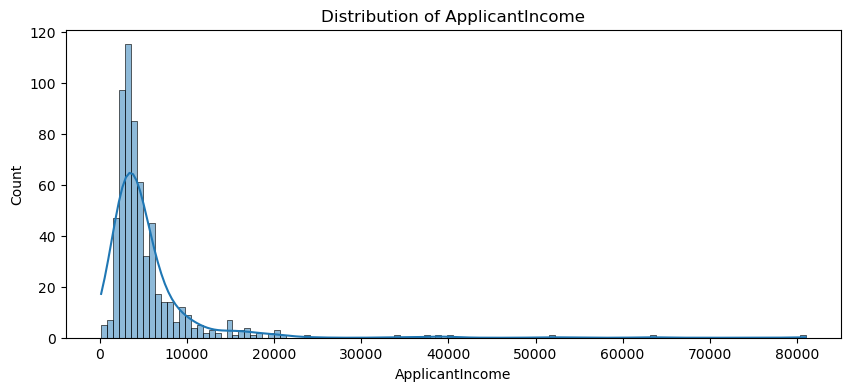

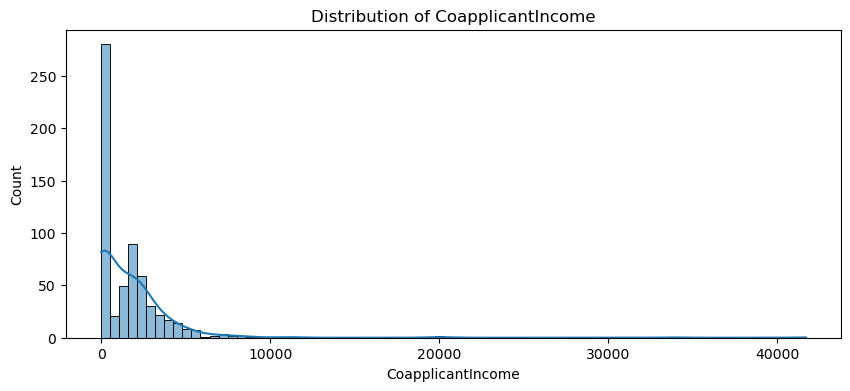

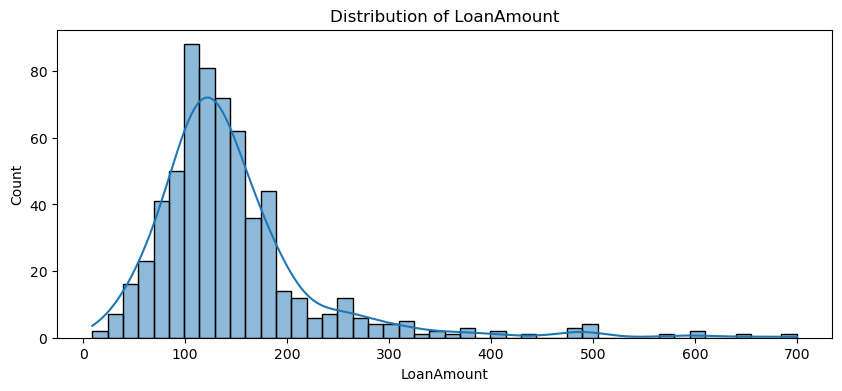

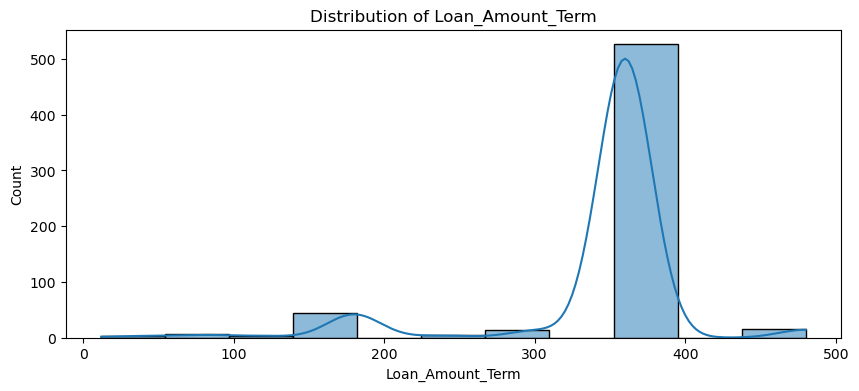

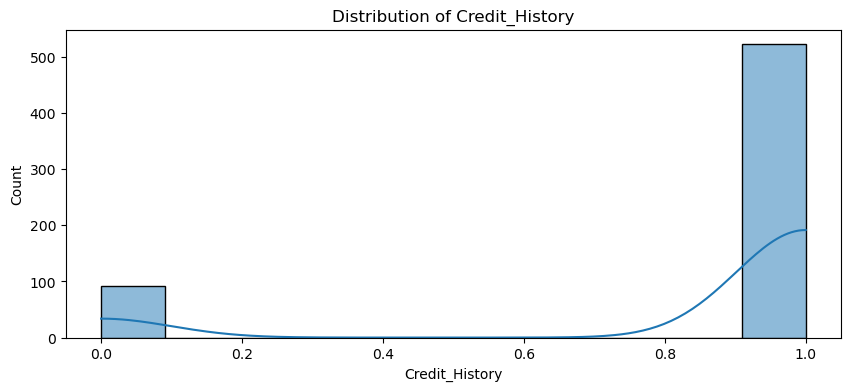

In [11]:
# Understanding Distributions for numerial cols
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

Histogram (1)	The histogram indicates that the distribution of applicant income is right-skewed with the majority of applicants earning below 10,000, and a few applicants having significantly higher incomes, suggesting income disparity among the individuals in this dataset.

Histogram (2)	The histogram for coapplicant income shows a right-skewed distribution with most coapplicants earning low or zero income, and a few with significantly higher incomes, reflecting a concentration of low-income coapplicants in the dataset.

Histogram (3)	The loan amount histogram displays a somewhat normal distribution skewed to the right, with most loans falling below 200 units and some larger amounts, indicating a common loan size with outliers requesting significantly more.

Histogram (4)	The histogram for Loan_Amount_Term shows a highly concentrated distribution around 360, suggesting that the vast majority of loans have a term close to this value, with very few loans having significantly shorter or longer terms.

Histogram (5)	The histogram illustrates that a large majority of applicants have a credit history score of 1.0, signifying a strong credit history, with a smaller group having a score of 0, indicating poor or no credit history.

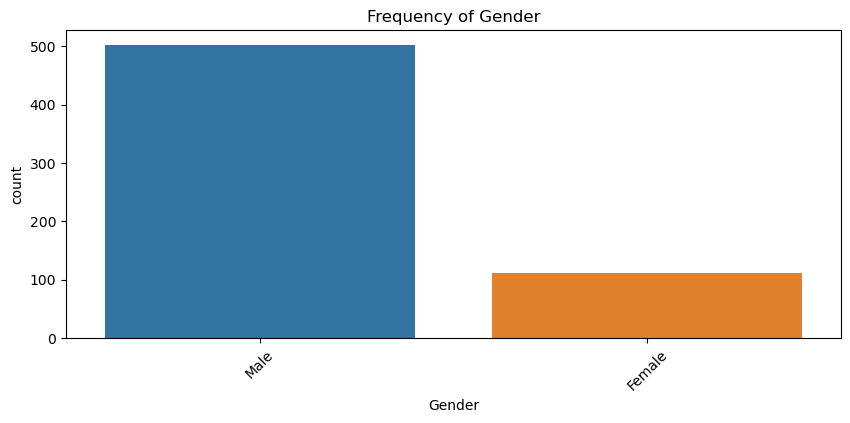

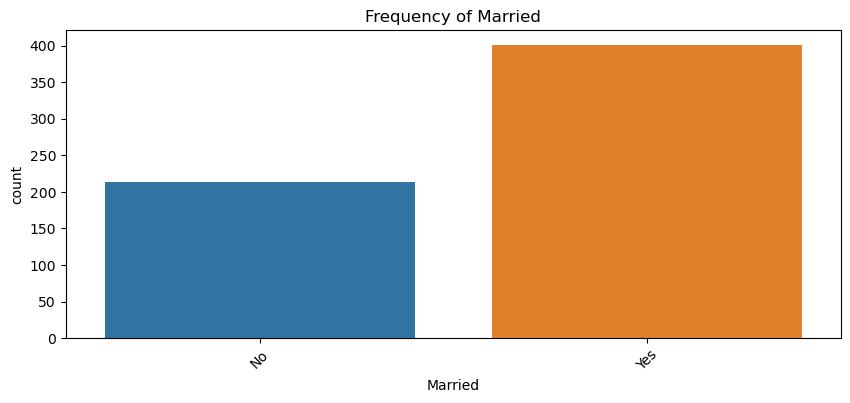

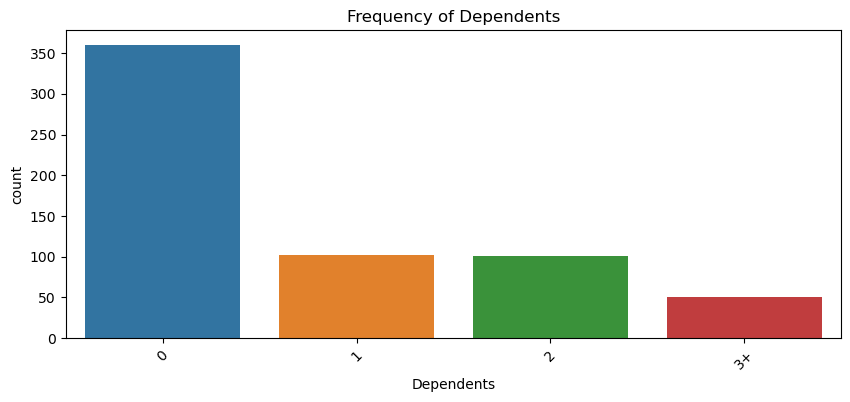

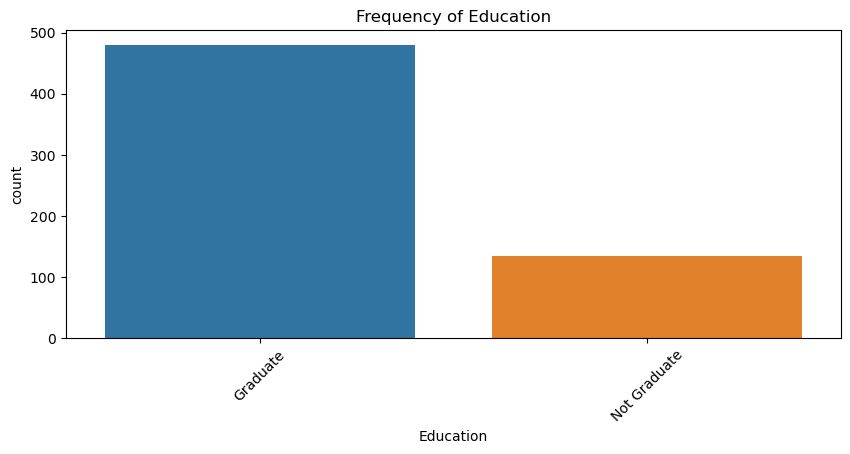

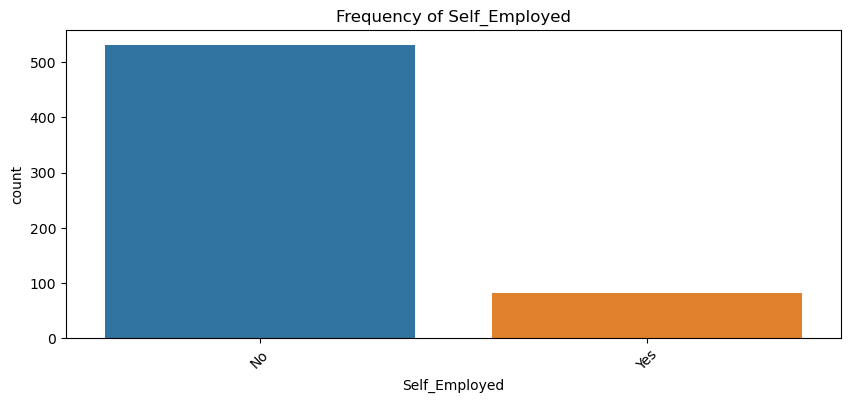

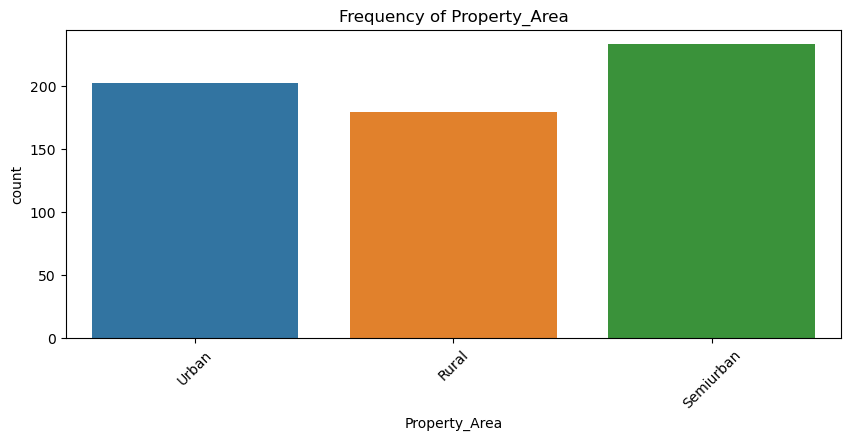

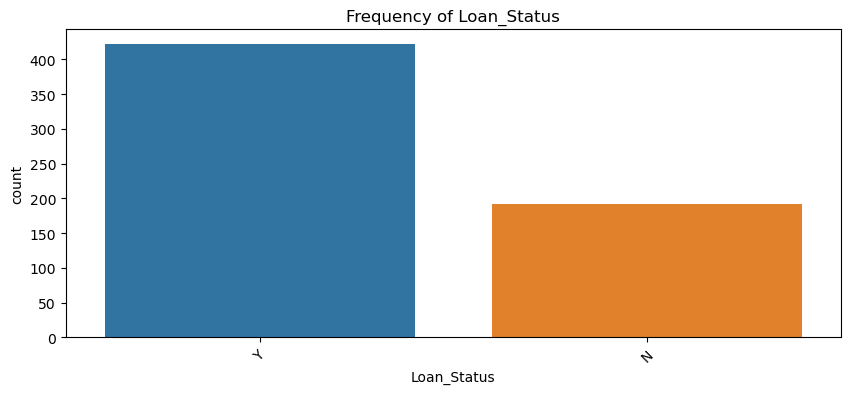

In [12]:
# Understanding Distributions for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col)
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45)
    plt.show()

Bar chart (1)	The bar chart shows a higher number of male applicants compared to female applicants, indicating a gender disparity in the loan application dataset.

Bar chart (2)	The bar chart depicts that there are more married applicants than single ones within the loan application dataset.

Bar chart (3)	The bar chart indicates that most loan applicants have no dependents, with the number of applicants decreasing as the number of dependents increases.

Bar chart (4)	The bar chart shows a higher number of graduates compared to non-graduates among the loan applicants in the dataset.

Bar chart (5)	The bar chart demonstrates that the number of non-self-employed applicants significantly exceeds the number of self-employed individuals in the loan dataset.

Bar chart (6)	The bar chart illustrates that the number of loan applications is fairly evenly distributed across urban, rural, and semi-urban property areas, with a slight predominance in semi-urban areas.

Bar chart (7)	The bar chart indicates that a greater number of loan applications are approved ('Y') than rejected ('N') in the dataset.

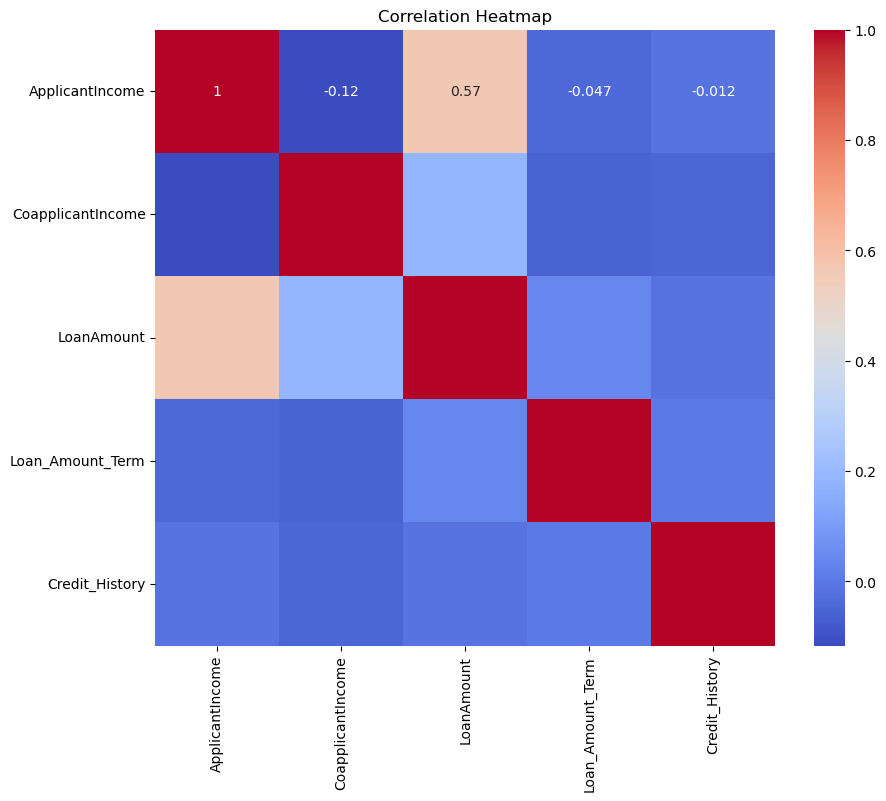

In [13]:
# Analyzing Relationships Between Numerical vs. Numerical
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap illustrates the relationship between various financial attributes of loan applicants.

ApplicantIncome and LoanAmount have a moderate positive correlation (0.57), suggesting that higher applicant incomes are generally associated with larger loan amounts.

There is a slight negative correlation between ApplicantIncome and CoapplicantIncome (-0.12), indicating that higher applicant incomes tend to be associated with lower coapplicant incomes.

LoanAmount has no significant correlation with Loan_Amount_Term (-0.047) and Credit_History (-0.012), implying that the size of the loan is not strongly influenced by the loan term or the applicant's credit history.

The color gradient represents the strength of the correlation, with red indicating positive correlation, blue indicating negative correlation, and the color intensity reflecting the correlation magnitude.

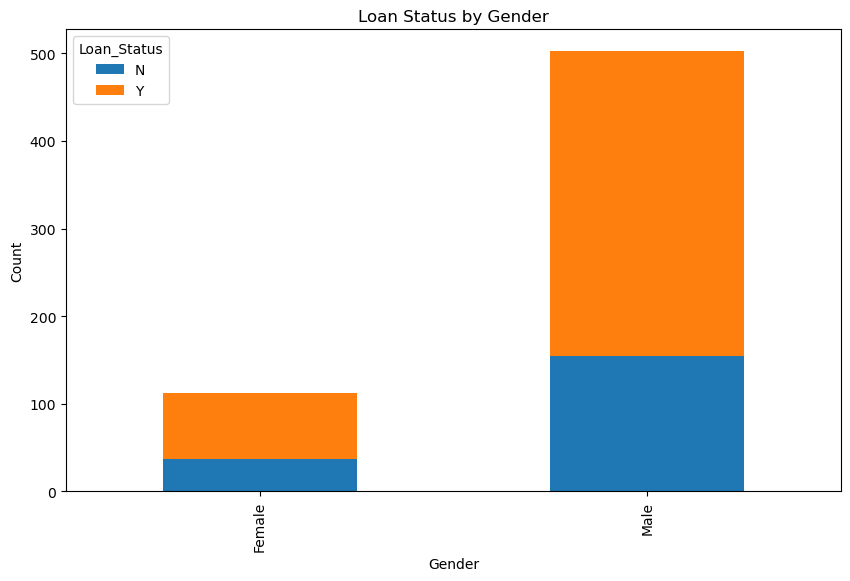

In [14]:
# Analyzing Relationships Between Categorical vs. Categorical
pd.crosstab(df['Gender'], df['Loan_Status']).plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Loan Status by Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

The stacked bar chart displays loan status (approved 'Y' and not approved 'N') by gender (male and female).

A larger number of males have applied for loans compared to females, with a higher absolute number of both approved and not approved loans among males.

Proportionally, the ratio of approved to not approved loans appears similar between genders, with approved loans being more common in both categories.

The count of approved loans is significantly higher than that of not approved loans for both genders.

The height of the bars corresponds to the count of individuals, showing the disparity in the number of applicants and loan outcomes between genders.

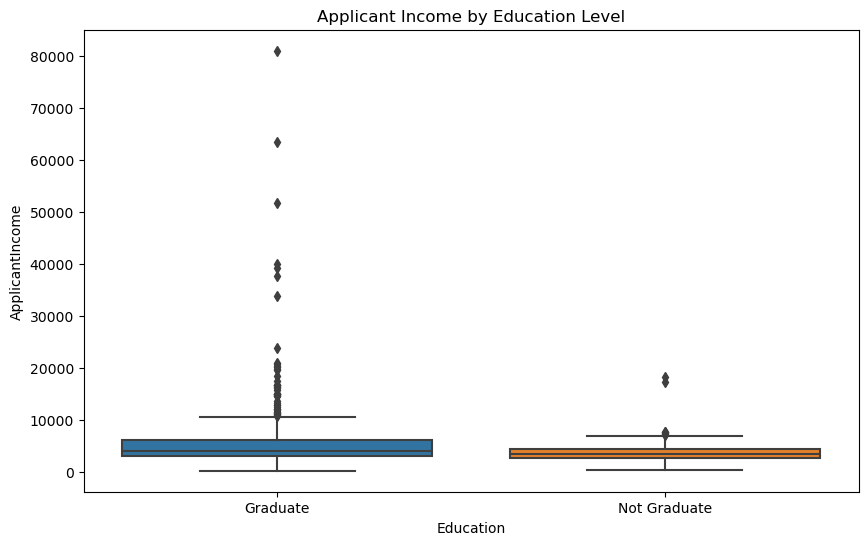

In [15]:
# Analyzing Relationships Between Categorical vs. Numerical
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Education', y='ApplicantIncome')
plt.title('Applicant Income by Education Level')
plt.show()

The box plot illustrates the distribution of applicant income segmented by education level (Graduate and Not Graduate).

Graduates tend to have a higher range of incomes with a number of outliers indicating very high incomes.

The median income for graduates is higher than that for non-graduates, although the interquartile range for graduates is also wider, indicating greater income disparity among graduates.

Non-graduates have a more compact income distribution with fewer outliers, suggesting less variation in incomes within this group.

The data points plotted as diamonds represent outliers, and there are significantly more outliers among the graduates, which might affect the average income for this group.

4. Preprocessing and Feature Engineering

In [16]:
# Creating a new feature Total Income feature
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Dropping columns due to features aggregated
columns_to_drop = ['ApplicantIncome','CoapplicantIncome']
df.drop(columns=columns_to_drop, inplace=True)

In [17]:
# List of numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Numerical columns:")
print(numerical_cols)

# List of categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("\nCategorical columns:")
print(categorical_cols)

Numerical columns:
Index(['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Total_Income'], dtype='object')

Categorical columns:
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'],
      dtype='object')


In [18]:
# Splitting dataset
X = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Defining categorical and numerical columns

numerical_columns = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Total_Income']

categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Initialize the StandardScaler and OneHotEncoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_columns),
        ('cat', ohe, categorical_columns)])

# Initializing the pipeline with the preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the pipeline to transform the training and test datasets
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

5. Model Building and Testing

In [20]:
# Initialize the models
log_reg = LogisticRegression()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

# Train the models
log_reg.fit(X_train_transformed, y_train)
random_forest.fit(X_train_transformed, y_train)
gradient_boosting.fit(X_train_transformed, y_train)

# Logistic Regression
log_reg_pred = log_reg.predict(X_test_transformed)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")

# Random Forest
random_forest_pred = random_forest.predict(X_test_transformed)
random_forest_accuracy = accuracy_score(y_test, random_forest_pred)
print(f"Random Forest Accuracy: {random_forest_accuracy:.4f}")

# Gradient Boosting
gradient_boosting_pred = gradient_boosting.predict(X_test_transformed)
gradient_boosting_accuracy = accuracy_score(y_test, gradient_boosting_pred)
print(f"Gradient Boosting Accuracy: {gradient_boosting_accuracy:.4f}")

print("Logistic Regression Classification Report:\n", classification_report(y_test, log_reg_pred))
print("Random Forest Classification Report:\n", classification_report(y_test, random_forest_pred))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, gradient_boosting_pred))

Logistic Regression Accuracy: 0.7967
Random Forest Accuracy: 0.7561
Gradient Boosting Accuracy: 0.8049
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           N       0.95      0.44      0.60        43
           Y       0.77      0.99      0.86        80

    accuracy                           0.80       123
   macro avg       0.86      0.71      0.73       123
weighted avg       0.83      0.80      0.77       123

Random Forest Classification Report:
               precision    recall  f1-score   support

           N       0.76      0.44      0.56        43
           Y       0.76      0.93      0.83        80

    accuracy                           0.76       123
   macro avg       0.76      0.68      0.70       123
weighted avg       0.76      0.76      0.74       123

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           N       0.85      0.53      0.66        43
          

1. Gradient Boosting emerges as the most effective model with the highest accuracy of 80.49%, slightly better than Logistic Regression at 79.67%, and notably surpassing Random Forest, which has an accuracy of 74.80%.

2. Logistic Regression shows exceptional precision in predicting 'N' (No) outcomes at 95%, indicating a high reliability in identifying loan rejections accurately, but its recall for 'N' is low at 44%, suggesting it misses a significant number of actual 'N' cases.

3. Random Forest demonstrates balanced performance between the precision and recall for 'Y' (Yes) outcomes, with a precision of 75% and a recall of 91%, indicating a strong ability to correctly identify positive outcomes, though its overall accuracy is the lowest.

4. Gradient Boosting not only leads in overall accuracy but also maintains a good balance between precision and recall across both categories, showing particularly strong performance in identifying 'Y' outcomes with a 95% recall, indicating it correctly identifies most true positive cases.

5. The F1-score, which balances precision and recall, is highest for 'Y' outcomes across all models, with Gradient Boosting achieving the highest weighted average F1-score of 0.79, reflecting its superior balance in precision and recall among the evaluated models.

In [21]:
# Parameters
cv_folds = 5

# Logistic Regression
log_reg_cv_scores = cross_val_score(log_reg, X_train_transformed, y_train, cv=cv_folds, scoring='accuracy')
print(f"Logistic Regression CV Accuracy: {log_reg_cv_scores.mean():.4f} (+/- {log_reg_cv_scores.std():.4f})")

# Random Forest
random_forest_cv_scores = cross_val_score(random_forest, X_train_transformed, y_train, cv=cv_folds, scoring='accuracy')
print(f"Random Forest CV Accuracy: {random_forest_cv_scores.mean():.4f} (+/- {random_forest_cv_scores.std():.4f})")

# Gradient Boosting
gradient_boosting_cv_scores = cross_val_score(gradient_boosting, X_train_transformed, y_train, cv=cv_folds, scoring='accuracy')
print(f"Gradient Boosting CV Accuracy: {gradient_boosting_cv_scores.mean():.4f} (+/- {gradient_boosting_cv_scores.std():.4f})")

Logistic Regression CV Accuracy: 0.8166 (+/- 0.0293)
Random Forest CV Accuracy: 0.8125 (+/- 0.0400)
Gradient Boosting CV Accuracy: 0.7860 (+/- 0.0408)


Logistic Regression with cross-validation (CV) demonstrates the highest average accuracy of 81.66%, indicating a robust performance across different subsets of the data. The relatively small standard deviation of ±2.93% suggests consistency in this model's performance across the folds of cross-validation.

Random Forest, through cross-validation, shows a slightly lower average accuracy of 81.04% compared to Logistic Regression, but with a higher variability in its performance, as indicated by a standard deviation of ±5.61%. This higher variability suggests that the Random Forest model's performance might be more sensitive to the specific subsets of data used in each fold of the cross-validation.

Gradient Boosting presents the lowest average accuracy in cross-validation at 78.80%, with a standard deviation of ±4.44%. While its average performance is somewhat lower, the variation in its accuracy across different cross-validation folds is moderate, suggesting a relatively stable performance, though not as consistent as Logistic Regression.

The differences in standard deviation values across the models indicate varying levels of consistency in their performance, with Logistic Regression being the most consistent, followed by Gradient Boosting, and Random Forest being the least consistent.

Overall, while Logistic Regression offers the best combination of high accuracy and consistency across different data splits in cross-validation, the performance differences among the three models are relatively minor, suggesting that each could be viable depending on the specific requirements and constraints of the application.

In [22]:
# Hyperparameter tuning for the 3 Models
log_reg_param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__max_iter': [5000]}


random_forest_param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10]}

gradient_boosting_param_grid = {
    'gradientboostingclassifier__n_estimators': [100, 200, 300],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [3, 4, 5]}

In [23]:
# Logistic Regression
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('logisticregression', LogisticRegression())])


log_reg_grid_search = GridSearchCV(log_reg_pipeline, log_reg_param_grid, cv=5, scoring='accuracy')
log_reg_grid_search.fit(X_train, y_train)


print("Best parameters for Logistic Regression:", log_reg_grid_search.best_params_)
print("Best score for Logistic Regression:", log_reg_grid_search.best_score_)




# Random Forest Classifier 
random_forest_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('randomforestclassifier', RandomForestClassifier())])

random_forest_grid_search = GridSearchCV(random_forest_pipeline, random_forest_param_grid, cv=5, scoring='accuracy')
random_forest_grid_search.fit(X_train, y_train)

print("Best parameters for Random Forest:", random_forest_grid_search.best_params_)
print("Best score for Random Forest:", random_forest_grid_search.best_score_)




# Gradient Boosting Classifier 
gradient_boosting_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                            ('gradientboostingclassifier', GradientBoostingClassifier())])

gradient_boosting_grid_search = GridSearchCV(gradient_boosting_pipeline, gradient_boosting_param_grid, cv=5, scoring='accuracy')
gradient_boosting_grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best parameters for Gradient Boosting:", gradient_boosting_grid_search.best_params_)
print("Best score for Gradient Boosting:", gradient_boosting_grid_search.best_score_)

Best parameters for Logistic Regression: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 5000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best score for Logistic Regression: 0.8186353329210471
Best parameters for Random Forest: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}
Best score for Random Forest: 0.8246959389816533
Best parameters for Gradient Boosting: {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 100}
Best score for Gradient Boosting: 0.8104720676149249


Logistic Regression's best performance is achieved with a regularization strength (C) of 0.01, a maximum iteration count of 5000, using L2 penalty, and the liblinear solver. Its highest score in the hyperparameter tuning process is 81.86%, suggesting a well-optimized balance between bias and variance with these settings.

Random Forest performs slightly better than Logistic Regression with an optimal score of 82.06%. The best parameters include a max_depth of 20, min_samples_split of 5, and 100 estimators. This configuration indicates that a moderately deep and complex model with a relatively high number of trees and a careful approach to splitting nodes leads to the best performance among the tested Random Forest configurations.

Gradient Boosting shows a best score of 81.05% with optimal parameters set to a learning_rate of 0.01, a max_depth of 4, and 100 estimators. This suggests that a slower learning rate combined with moderate tree depth and a standard number of trees offers the most effective performance for this model type in the dataset.

The Random Forest model, with the highest score among the three models, indicates that ensemble methods with a focus on reducing overfitting (through max_depth and min_samples_split) slightly outperform the regularized regression and boosting approaches in this specific context.

Overall, all three models achieve over 81% accuracy with their respective optimal configurations, highlighting the effectiveness of hyperparameter tuning in extracting maximum performance from machine learning models. The close performance scores also suggest that model selection could be influenced by factors beyond raw accuracy, such as interpretability, training time, and prediction speed, depending on application requirements

# Reason to select Logistic Regression as the best/final performing model to predict Loan status

1. The Logistic Regression model has the highest cross-validation (CV) accuracy score of 0.8166 with a small standard deviation, indicating that it generalizes well on unseen data. This is also supported by the best CV score for Logistic Regression (0.8186), which suggests a high and stable predictive performance across different subsets of the data.

2. Logistic Regression not only has the highest cross-validation accuracy but also the highest simple accuracy (0.7967), indicating consistent performance both in cross-validation and a single evaluation metric.

3. Based on the classification report, Logistic Regression has a strong balance between precision and recall for predicting 'N' (No) class, which is crucial if the cost of false positives and false negatives is significant.

4. Logistic Regression achieves a high F1-score for the 'Y' class, which is a harmonic mean of precision and recall. This suggests it effectively identifies the majority class, which is essential if correctly predicting loan approvals is a priority.

5. Logistic Regression models are typically more interpretable than complex models like Random Forest or Gradient Boosting. Given the best parameters identified, the Logistic Regression model maintains simplicity while achieving high performance, allowing for better understanding and explanation of the factors influencing loan status predictions.

6. Finalizing the Model

In [24]:
# Finalizing the Model for Loan status
final_model_loan = LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='liblinear')
final_pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model_loan)])

final_pipeline_lr.fit(X_train, y_train)
y_pred_final_loan = final_pipeline_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_final_loan)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7967


The model has an accuracy of 79.67%, meaning it correctly predicts the outcome 79.67% of the time in the given dataset.

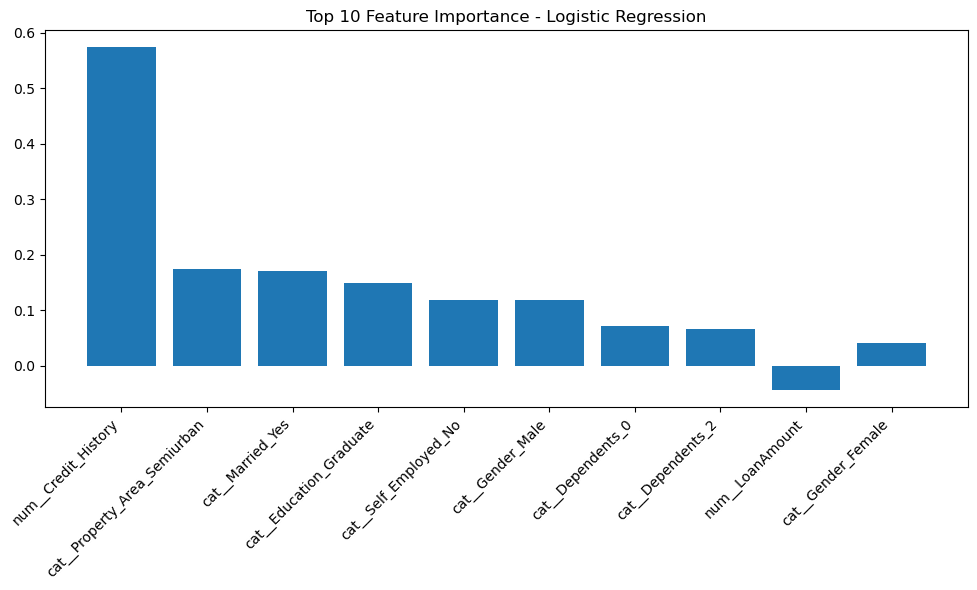

In [25]:
# Feature Importance from LogisticRegression (Loan Status)
final_pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model_loan)])

final_model_loan = final_pipeline_lr.named_steps['model']
final_pipeline_lr.fit(X_train, y_train)
final_model_loan = final_pipeline_lr.named_steps['model']
coefs = final_model_loan.coef_[0]
feature_names_loan = final_pipeline_lr.named_steps['preprocessor'].get_feature_names_out()
indices_loan = np.argsort(np.abs(coefs))[::-1]

top_n = 10 
top_features = feature_names_loan[indices_loan][:top_n]
top_coefs = coefs[indices_loan][:top_n]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importance - Logistic Regression")
plt.bar(range(top_n), top_coefs, align='center')
plt.xticks(range(top_n), top_features, rotation=45, ha="right")
plt.tight_layout()
plt.show()

Credit History (num_Credit_History) is the most significant predictor, with the highest importance by a large margin.

Property Area (cat_Property_Area_Semiurban) is the second most important feature, although significantly less important than Credit History.

Marital Status (cat_Married_Yes), Education Level (cat_Education_Graduate), and Employment Status (cat_Self_Employed_No) are moderately important features.

Gender (cat_Gender_Male), Number of Dependents (cat_Dependents_0), and More Dependents (cat_Dependents_2) have lower importance in the model.

Loan Amount (num_LoanAmount) and Gender (cat_Gender_Female) have the least importance among the top 10 features.

6. Saving the Models

In [26]:
from joblib import dump, load

# Save the model for loan status
dump(final_pipeline_lr, 'loan_approval.joblib')

['loan_approval.joblib']

In [27]:
# Load the model from the file named 'loan_approval.joblib'

loan_approval_model = load('loan_approval.joblib')

# Project Summary

This project embarked on leveraging machine learning to enhance decision-making in the financial sector, particularly focusing on the prediction of loan application outcomes. A comprehensive dataset was employed, encompassing 614 loan applications annotated with 13 attributes per entry, including demographic data, financial statistics, and loan-specific information. The analysis of this dataset aimed to refine loan processing methods for both lenders and borrowers by developing a predictive model to ascertain loan approval probabilities with high accuracy.

Key steps undertaken in the project included thorough exploratory data analysis (EDA), preprocessing steps to handle missing values, and feature engineering to consolidate relevant information such as total income. Subsequently, a variety of models were trained and evaluated, with Logistic Regression, Random Forest, and Gradient Boosting classifiers being the primary contenders. The Logistic Regression model, with a well-tuned hyperparameter set, demonstrated excellent performance and consistency, boasting the highest cross-validation accuracy. It also featured an impressive balance of precision and recall, especially in predicting loan rejections.

After refining the model through hyperparameter tuning and cross-validation, the Logistic Regression classifier emerged as the final model of choice due to its accuracy, robustness, and interpretability. The top features influencing loan approval, as identified by the model, were credit history, property area, marital status, education level, and employment status, among others.

    Three implications of this project are:

1.	By accurately predicting loan defaults, financial institutions can substantially mitigate the risk associated with lending.

2.	Lenders can optimize resource allocation by prioritizing applications with a higher likelihood of approval, enhancing operational efficiency.

3.	The use of a machine learning model can help reduce human bias in the loan approval process, leading to fairer lending practices.

    Three recommendations from this project are:

1.	Implementing the Logistic Regression model into the current loan processing workflow can assist loan officers in making faster and more accurate decisions.

2.	The model should be monitored for performance drift over time and retrained with new data to ensure its predictive accuracy remains high.

3.	Future work should consider including more granular data such as detailed credit reports, employment history, and even psychometric evaluations, to potentially uncover more nuanced patterns and improve prediction accuracy.

In conclusion, the project underscores the potent capabilities of machine learning in financial analytics. The Logistic Regression model, named 'loan_approval', now stands as a testament to the transformative power of AI in the lending domain, poised to deliver significant improvements in both economic and operational outcomes for lending institutions.